In [ ]:
import numpy as np
import freegs
from freegs.plotting import plotConstraints
from freegs.critical import find_critical
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import sys
import matplotlib.pyplot as plt
from copy import deepcopy
from IPython.display import display, clear_output
import time

In [ ]:
%matplotlib inline

In [ ]:
%load_ext autoreload

In [ ]:
%autoreload 2

In [101]:
# Create the machine, which specifies coil locations
# and equilibrium, specifying the domain to solve over
# this has to be either
# freegs.machine.MASTU(), in which case:
#tokamak = freegs.machine.MASTU()
# or
# MASTU_coils.MASTU_wpass()
from freegsnke import MASTU_coils
tokamak = MASTU_coils.MASTU_wpass()


# Creates equilibrium object and initializes it with 
# a "good" solution
plasma_psi = np.loadtxt('plasma_psi_example.txt')
eq = freegs.Equilibrium(tokamak=tokamak,
                        #domains can be changed in principle, 
                        #in practice domains as below are used to detect
                        #plasma hitting the wall during evolution
                        Rmin=0.1, Rmax=2.0,    # Radial domain
                        Zmin=-2.2, Zmax=2.2,   # Height range
                        #grid resolution can be changed
                        nx=129, ny=129, # Number of grid points
                        psi=plasma_psi)     

# Sets desired plasma properties for the 'starting equilibrium'
# values can be changed
profiles = freegs.jtor.ConstrainPaxisIp(40e3, # Plasma pressure on axis [Pascals]
                                        6e5, # Plasma current [Amps]
                                        0.5, # vacuum f = R*Bt
                                        alpha_m = 1.0,
                                        alpha_n = 2.0)


# Sets some shape constraints (here very close to those used for initialization)
Rx = 0.55
Zx = 1.05

Rmid = 1.3   # Outboard midplane
Rin = 0.4  # Inboard midplane

xpoints = [(Rx, -Zx),   # (R,Z) locations of X-points
           (Rx,  Zx)]
isoflux = [
    #if geometry is changed considerably, it can be useful to  
    #start by imposing this first set of constraints only
           (Rx,Zx, Rx,-Zx),
           (Rmid, 0, Rin, 0.0),
           (Rmid,0, Rx,Zx),
    
           
    #then adding all of the following
           (Rx,-Zx, 1, -0.9),
           (Rx,-Zx, Rmid, -0.4),   # Outboard midplane, lower X-point
           (Rx,Zx, Rmid, +0.4),   # Outboard midplane, upper X-point
           (Rx,Zx, 1, +0.9),
           
           

       #     # Link inner and outer midplane locations
           (Rx, Zx, .5, 1.25),
           (Rx, Zx, Rin, 0.2),
           (Rx, Zx, Rin, 0.1),
           (Rx,-Zx, Rin, -0.1),
           (Rx,-Zx, Rin, -0.2),
           (Rx, -Zx, .5, -1.25),

#       # Separatrix in the divertor chamber
           (Rx,-Zx, 0.6, -1.45),
           (Rx, Zx, 0.6,  1.45),
           
           (Rx,-Zx, 0.68, -1.55),
           (Rx, Zx, 0.68,  1.55),
           
           (Rx,-Zx, 0.8, -1.7),
           (Rx, Zx, 0.8,  1.7),
           
           (Rx,-Zx, 0.9, -1.75),
           (Rx, Zx, 0.9,  1.75),
           
            (Rx,-Zx, 1., -1.8),
            (Rx, Zx, 1.,  1.8),
           
            (Rx,-Zx, 1.1, -1.9),
            (Rx, Zx, 1.1,  1.9),

            (Rx,-Zx, 1.2, -1.9),
            (Rx, Zx, 1.2,  1.9),

            (Rx,-Zx, 1.3, -2),
            (Rx, Zx, 1.3,  2),

       

       #     (Rx,-Zx, 2, -1.85),
       #     (Rx, Zx, 2,  1.85),

         #   (Rx,-Zx, 1.5, -1.85),
         #   (Rx, Zx, 1.5,  1.85),

         #   (Rx,-Zx, 1.6, -1.85),
         #   (Rx, Zx, 1.6,  1.85),

         #   (Rx,-Zx, 1.7, -1.85),
         #   (Rx, Zx, 1.7,  1.85),

         #   (Rx,-Zx, 1.8, -1.85),
         #   (Rx, Zx, 1.8,  1.85),

          
           
           
        # infra-coils separatrix
           (Rx,-Zx, .35, -1.3),
           (Rx, Zx, .35,  1.3),
           
       #     (Rx,-Zx, .5, -1.8),
       #     (Rx, Zx, .5,  1.8),
           
       #     (Rx,-Zx, .6, -1.9),
       #     (Rx, Zx, .6,  1.9),
    
        #    (Rx,-Zx, .7, -2.2),
        #    (Rx, Zx, .7,  2.2),
           ]

constrain = freegs.control.constrain(xpoints=xpoints, 
                                     gamma=8e-6, 
                                     isoflux=isoflux
                                    )
constrain(eq)

In [77]:
eq.tokamak['Solenoid'].current = -12300

In [79]:
eq.tokamak['P4'].current = 3000
eq.tokamak['Dp'].current = -8.000
eq.tokamak['Px'].current = -6000
eq.tokamak['D6'].current = -2000
eq.tokamak['D7'].current = -2000
eq.tokamak['D5'].current = 200

<AxesSubplot:xlabel='Major radius [m]', ylabel='Height [m]'>

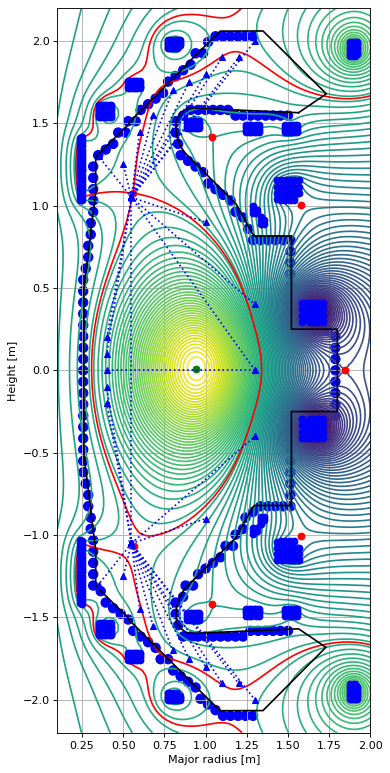

In [102]:
# Nonlinear solve
freegs.solve(eq,          # The equilibrium to adjust
             profiles,    # The plasma profiles
             constrain,   # Plasma control constraints
             show=False,
             rtol=1e-2)   
fig = plt.figure(figsize=(6, 12), dpi=80);
ax = fig.add_subplot(111);
ax.grid(True,which='both');
eq.plot(axis=ax,show=False);
eq.tokamak.plot(axis=ax,show=False);
constrain.plot(axis=ax,show=False)

In [103]:
# Initialize the evolution object
# This uses the starting equilibrium to get all the geometric constraints/grids etc
from freegsnke import evolve_plasma_NK
stepping = evolve_plasma_NK(profiles, eq)

# In absence of a policy, this calculates the active voltages U_active
# to maintain the currents needed for the equilibrium statically
U_active = np.matmul(stepping.evol_currents.R_matrix, stepping.currents_vec)[:MASTU_coils.N_active]

In [60]:
def get_O_points(eq):
    return find_critical(eq.R, eq.Z, eq.psi())[0][0]

def calculate_width(eq):
    inout = eq.innerOuterSeparatrix()
    return inout[1] - inout[0]

In [ ]:
# Example of evolution with constant applied voltages
t = 0
flag = 0
history_times = [t]
t_per_step = []

#use the following to reset stepping.eq1 to a new IC
stepping.initialize_from_ICs(eq,profiles)

history_currents = [stepping.currents_vec]
history_o_points = [get_O_points(stepping.eq1)]
history_equilibria = [deepcopy(stepping.eq1)]
history_width = [calculate_width(stepping.eq1)]
history_elongation = [stepping.eq1.geometricElongation()]

counter = 0
max_count = 30


In [ ]:
flag = stepping.do_step(U_active, 
                        max_rel_residual=.002,
                        verbose_currents=True,
                        rtol_currents=1e-3,
                        n_k=10,
                        max_iter=20,
                        conv_crit=.85,
                        grad_eps=.0005,
                        clip=2
                        )

In [ ]:
stepping.currents_vec

In [ ]:
stepping.evol_currents.initialize_time_t(stepping.results)
stepping.evol_currents.determine_stepsize(stepping.dt_step, .0001)

In [ ]:
stepping.trial_currents = stepping.evol_currents.stepper_adapt_first(stepping.currents_vec, U_active, stepping.dR)

In [ ]:
Fresidual = stepping.Fcircuit(stepping.trial_currents, 1e-6, False)
rel_change = abs(Fresidual)#/stepping.vals_for_rel_change
max_rel_change = max(rel_change)
max_rel_change

In [ ]:
stepping.dt_step *= .001/max_rel_change

In [ ]:
stepping.evol_currents.determine_stepsize(stepping.dt_step, .0001)
stepping.trial_currents1 = stepping.evol_currents.stepper_adapt_repeat(stepping.currents_vec, stepping.dR)

In [ ]:
plt.plot(stepping.trial_currents-stepping.currents_vec)
plt.plot(stepping.trial_currents1-stepping.currents_vec)

In [ ]:
stepping.dt_step

In [ ]:
Fresidual1 = stepping.Fcircuit(stepping.trial_currents1, 1e-6, False)

In [ ]:
rel_change = abs(Fresidual1)
max_rel_change = max(rel_change)
max_rel_change

In [ ]:
plt.plot(Fresidual)
plt.plot(Fresidual1)

In [ ]:
stepping.evol_currents.stepper_adapt_repeat(stepping.currents_vec, stepping.dR)

In [ ]:
abs_currents = abs(stepping.currents_vec)
stepping.vals_for_rel_change = np.where(abs_currents>stepping.threshold, abs_currents, stepping.threshold)


In [ ]:
stepping.Fcircuit(stepping.trial_currents, 1e-6, False)

In [ ]:
stepping.dt_step = .001

In [ ]:
flag = stepping.do_step(U_active, 
                        max_rel_residual=.001,
                        verbose_currents=True,
                        rtol_currents=3e-4,
                        n_k=10,
                        max_iter=20,
                        conv_crit=.5,
                        grad_eps=.003,
                        clip=2
                        )

In [ ]:
invm = np.linalg.inv(stepping.evol_currents.R_matrix[:-1,:-1]+MASTU_coils.coil_self_ind/.001)
v, w = np.linalg.eig(np.matmul(invm, MASTU_coils.coil_self_ind/.001))
w = np.append(w[:,:50], 1e-5*np.ones((1,50)), axis=0)

In [ ]:
np.random.randint(10)

In [ ]:
i = 0
j = 2
np.sum(stepping.G[:,i]*stepping.G[:,j])/(np.linalg.norm(stepping.G[:,i])*np.linalg.norm(stepping.G[:,j]))

In [ ]:
plt.plot(stepping.G[:,i])
plt.plot(stepping.G[:,j])

In [ ]:
abs_currents = abs(stepping.currents_vec)
stepping.vals_for_rel_change = np.where(abs_currents>stepping.threshold, abs_currents, stepping.threshold)

stepping.dt_step = .002

In [ ]:
stepping.dt_step /=10

In [ ]:
stepping.evol_currents.initialize_time_t(stepping.results)
stepping.evol_currents.determine_stepsize(stepping.dt_step, .0002)

In [ ]:
stepping.evol_currents.n_step

In [ ]:
stepping.trial_currents = stepping.evol_currents.stepper_adapt(stepping.currents_vec, U_active, stepping.dR)

In [ ]:
stepping.dR

In [ ]:
stepping.trial_currents[54]

In [ ]:
(Fresidual1/stepping.vals_for_rel_change)[54]

In [ ]:
Fresidual1 = stepping.Fcircuit(U_active, stepping.trial_currents)
Fresidual1

In [ ]:
Fresidual = stepping.Fcircuit(U_active, stepping.trial_currents)
Fresidual

In [ ]:
stepping.dR = stepping.update_R_matrix(stepping.trial_currents)

In [ ]:
stepping.eq2.plasma_psi = stepping.eq1.plasma_psi.copy()

In [ ]:
max(rel_change1)

In [ ]:
used_n

In [ ]:
stepping.coeffs

In [ ]:
stepping.currents_vec = stepping.trial_currents.copy()
stepping.eq1.plasma_psi = stepping.eq2.plasma_psi.copy()

In [ ]:
plt.plot(stepping.Q[:,1])

In [ ]:
this_is_first_step = 0

In [ ]:
i=10
plt.plot(stepping.arnoldi_trials[i,:-3], label=str(stepping.arnoldi_trials[i,-3])+str(stepping.arnoldi_trials[i,-2])+str(stepping.arnoldi_trials[i,-1]))
plt.legend()

In [ ]:
stepping.arnoldi_trials[:,-3:]

In [ ]:
abs_currents = abs(stepping.currents_vec)
stepping.vals_for_rel_change = np.where(abs_currents>stepping.threshold, abs_currents, stepping.threshold)

In [ ]:
stepping.do_LIdot(U_active, 
                stepping.currents_vec, 
                .001,
                results,
                stepping.dR)

In [ ]:
stepping.eq2.plasma_psi = stepping.eq1.plasma_psi.copy()


In [ ]:
di = stepping.dI(Fresidual, clip=100)
stepping.trial_currents += di

In [ ]:
rel_change = abs(Fresidual)/stepping.vals_for_rel_change
max(rel_change)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(stepping.evol_currents.L0_matrix>0)
plt.colorbar()

In [104]:
# Example of evolution with constant applied voltages
t = 0
flag = 0
history_times = [t]
t_per_step = []

#use the following to reset stepping.eq1 to a new IC
stepping.initialize_from_ICs(eq, profiles)

history_currents = [stepping.currents_vec]
history_o_points = [get_O_points(stepping.eq1)]
history_equilibria = [deepcopy(stepping.eq1)]
history_width = [calculate_width(stepping.eq1)]
history_elongation = [stepping.eq1.geometricElongation()]

counter = 0
max_count = 200
this_is_first_step = 1
while flag<1 and counter<max_count:
    clear_output(wait=True)
    display(f'Step: {counter}/{max_count-1}')
    
    t_start = time.time()
    flag = stepping.do_step(U_active, 
                        max_rel_residual=.0016,
                        verbose_currents=True,
                        rtol_currents=1e-3,
                        n_k=5,
                        max_iter=10,
                        conv_crit=.85,
                        grad_eps=.0005,
                        clip=2
                        )
    t_end = time.time()
    t_per_step.append(t_end-t_start)
    
    this_is_first_step = 0

    t += stepping.dt_step
    history_times.append(t)

    history_currents.append(stepping.currents_vec)
    history_o_points.append(get_O_points(stepping.eq1))
    history_equilibria.append(deepcopy(stepping.eq1))
    history_width.append(calculate_width(stepping.eq1))
    history_elongation.append(stepping.eq1.geometricElongation())
    counter += 1

history_currents = np.array(history_currents)
history_times = np.array(history_times)
history_o_points = np.array(history_o_points)

'Step: 195/199'

reducing timestep: 0.0022023832008572224 0.0024731575578362417 12 54
0.0005792944098539957 0.0013475352828010824 7 52
final timestep =  0.0013475352828010824
initial max_rel_change =  0.0005792944098539957 52 0.00010948818917953061
number of Arnoldi iterations =  0


In [ ]:
# Equilibrium evolution
fig, ax = plt.subplots(figsize=(5, 10), dpi=80)
ax.grid(True)
fig.subplots_adjust(bottom=0.25)
history_equilibria[0].plot(axis=ax, show=False)
ax.set_title(f't: {history_times[0]:.4f} s')

ax_i = fig.add_axes([0.25, 0.1, 0.65, 0.03])
i = np.arange(0, len(history_equilibria))
s = Slider(ax_i, "time step", 0, i[-1], valinit=0, valstep=i)
def update(val):
    ax.clear()
    ax.grid(True)
    i = s.val
    history_equilibria[i].plot(axis=ax, show=False)
    ax.set_title(f't: {history_times[i]:.4f} s')
    fig.canvas.draw_dile()
s.on_changed(update)

<AxesSubplot:xlabel='Major radius [m]', ylabel='Height [m]'>

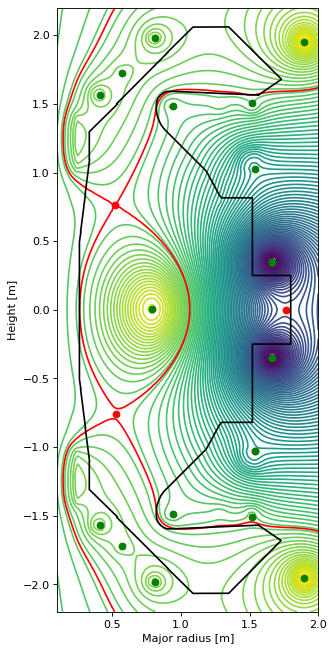

In [105]:
fig, ax = plt.subplots(figsize=(5, 10), dpi=80)
history_equilibria[-1].plot(axis=ax, show=False)

In [87]:
history_currents = np.array(history_currents)
history_times = np.array(history_times)
history_o_points = np.array(history_o_points)
history_width = np.array(history_width)
history_elongation = np.array(history_elongation)

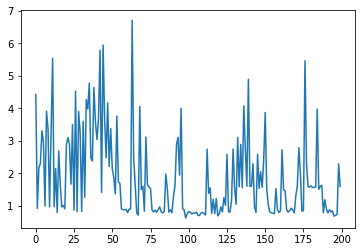

In [98]:
plt.plot(t_per_step)

Text(0, 0.5, 'Plasma elongation')

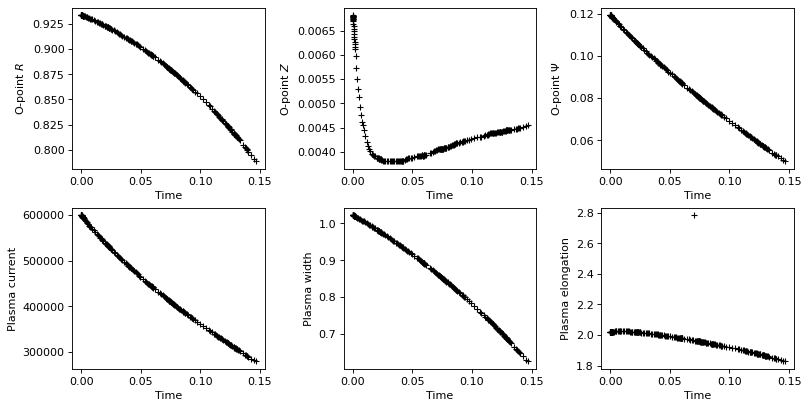

In [106]:
# Evolution of tracked values
fig, axs = plt.subplots(2, 3, figsize=(10, 5), dpi=80, constrained_layout=True)
axs_flat = axs.flat

axs_flat[0].plot(history_times, history_o_points[:, 0],'k+')
axs_flat[0].set_xlabel('Time')
axs_flat[0].set_ylabel('O-point $R$')

axs_flat[1].plot(history_times, history_o_points[:, 1],'k+')
axs_flat[1].set_xlabel('Time')
axs_flat[1].set_ylabel('O-point $Z$')

axs_flat[2].plot(history_times, history_o_points[:, 2],'k+')
axs_flat[2].set_xlabel('Time')
axs_flat[2].set_ylabel('O-point $\Psi$')

axs_flat[3].plot(history_times, history_currents[:,-1],'k+')
axs_flat[3].set_xlabel('Time')
axs_flat[3].set_ylabel('Plasma current')

axs_flat[4].plot(history_times, history_width,'k+')
axs_flat[4].set_xlabel('Time')
axs_flat[4].set_ylabel('Plasma width')

axs_flat[5].plot(history_times, history_elongation,'k+')
axs_flat[5].set_xlabel('Time')
axs_flat[5].set_ylabel('Plasma elongation')

In [ ]:
# Evolution of tracked values
fig, axs = plt.subplots(2, 3, figsize=(10, 5), dpi=80, constrained_layout=True)
axs_flat = axs.flat

axs_flat[0].plot(history_times1, history_o_points1[:, 0],'k+')
axs_flat[0].plot(history_times2, history_o_points2[:, 0],'r+')
axs_flat[0].set_xlabel('Time')
axs_flat[0].set_ylabel('O-point $R$')

axs_flat[1].plot(history_times1, history_o_points1[:, 1],'k+')
axs_flat[1].plot(history_times2, history_o_points2[:, 1],'r+')
axs_flat[1].set_xlabel('Time')
axs_flat[1].set_ylabel('O-point $Z$')

axs_flat[2].plot(history_times1, history_o_points1[:, 2],'k+')
axs_flat[2].plot(history_times2, history_o_points2[:, 2],'r+')
axs_flat[2].set_xlabel('Time')
axs_flat[2].set_ylabel('O-point $\Psi$')

axs_flat[3].plot(history_times1, history_currents1[:,-1],'k+')
axs_flat[3].plot(history_times2, history_currents2[:,-1],'r+')
axs_flat[3].set_xlabel('Time')
axs_flat[3].set_ylabel('Plasma current')

axs_flat[4].plot(history_times1, history_width1,'k+')
axs_flat[4].plot(history_times2, history_width2,'r+')
axs_flat[4].set_xlabel('Time')
axs_flat[4].set_ylabel('Plasma width')

axs_flat[5].plot(history_times1, history_elongation1,'k+')
axs_flat[5].plot(history_times2, history_elongation2,'r+')
axs_flat[5].set_xlabel('Time')
axs_flat[5].set_ylabel('Plasma elongation')

In [ ]:
# Evolution of tracked values
fig, axs = plt.subplots(2, 3, figsize=(10, 5), dpi=80, constrained_layout=True)
axs_flat = axs.flat

axs_flat[0].plot(history_times, history_o_points[:, 0],'k+')
axs_flat[0].set_xlabel('Time')
axs_flat[0].set_ylabel('O-point $R$')

axs_flat[1].plot(history_times, history_o_points[:, 1],'k+')
axs_flat[1].set_xlabel('Time')
axs_flat[1].set_ylabel('O-point $Z$')

axs_flat[2].plot(history_times, history_o_points[:, 2],'k+')
axs_flat[2].set_xlabel('Time')
axs_flat[2].set_ylabel('O-point $\Psi$')

axs_flat[3].plot(history_times, history_currents[:,-1],'k+')
axs_flat[3].set_xlabel('Time')
axs_flat[3].set_ylabel('Plasma current')

axs_flat[4].plot(history_times, history_width,'k+')
axs_flat[4].set_xlabel('Time')
axs_flat[4].set_ylabel('Plasma width')

axs_flat[5].plot(history_times, history_elongation,'k+')
axs_flat[5].set_xlabel('Time')
axs_flat[5].set_ylabel('Plasma elongation')

/var/folders/n4/g0m7y66n7qj77q_n9txgrcmh0000gq/T/ipykernel_4465/3948350522.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


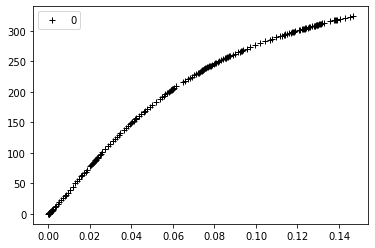

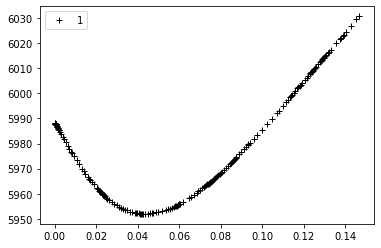

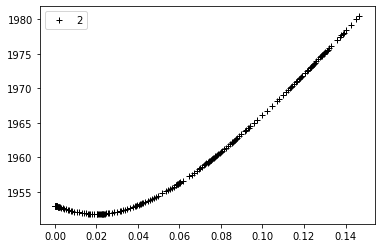

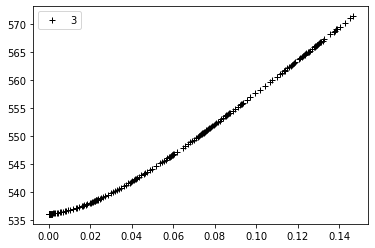

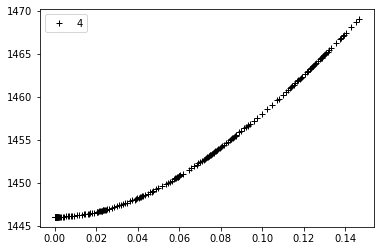

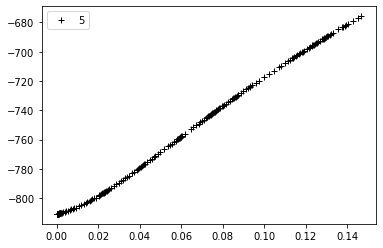

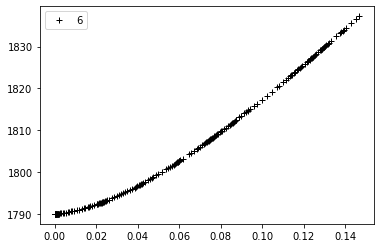

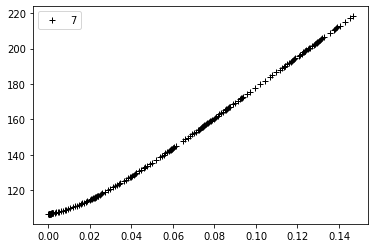

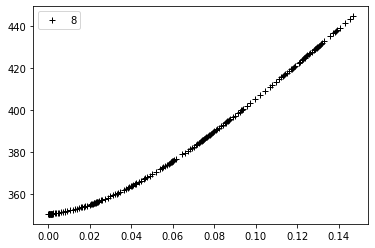

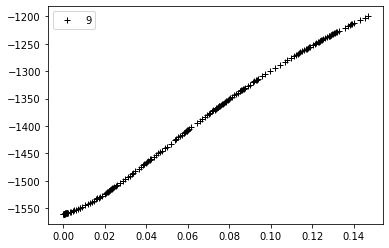

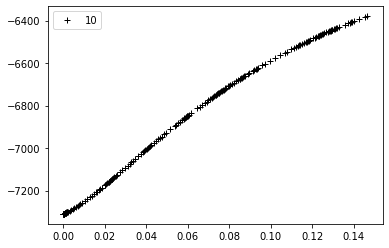

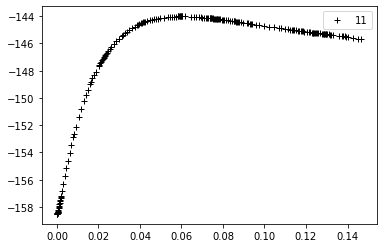

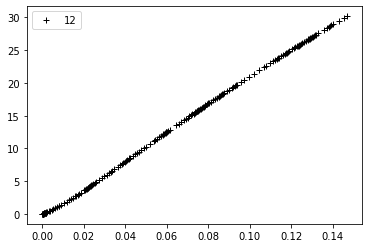

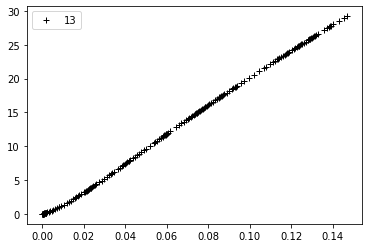

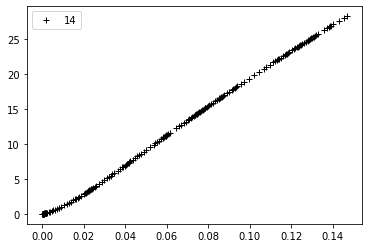

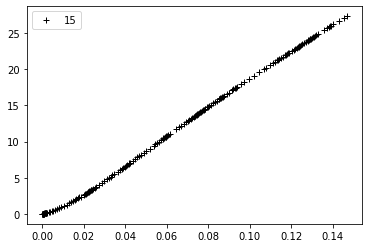

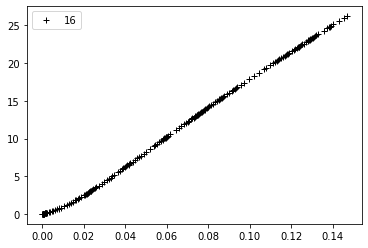

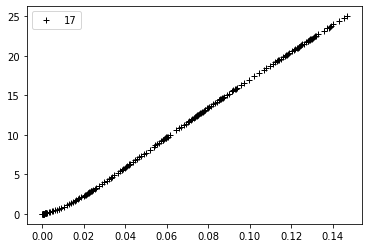

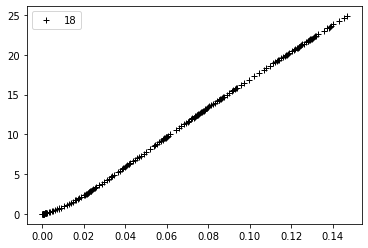

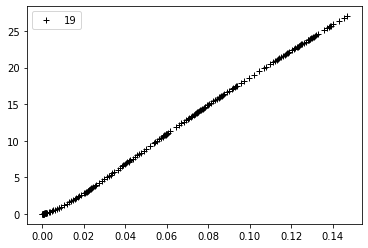

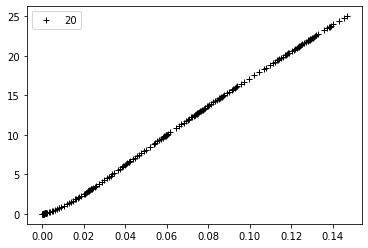

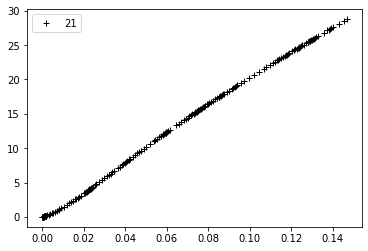

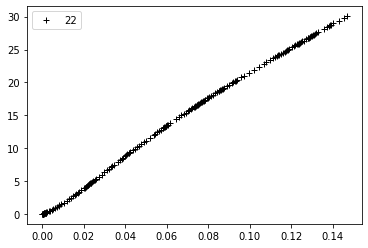

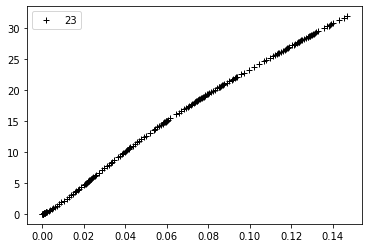

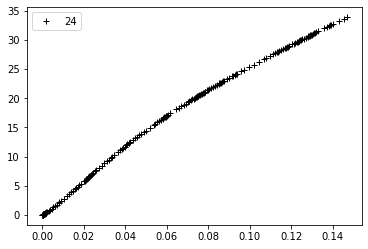

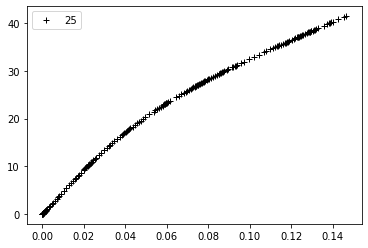

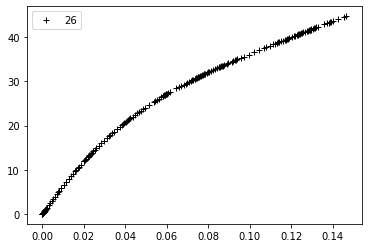

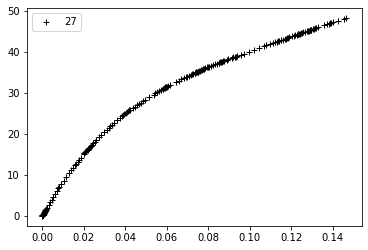

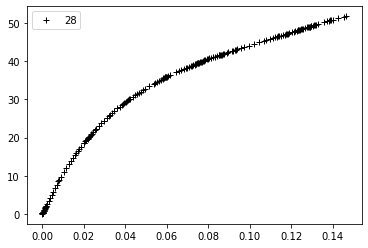

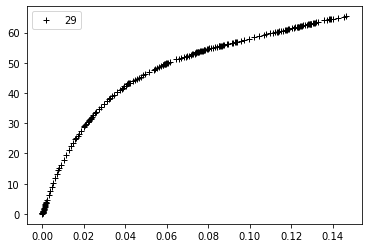

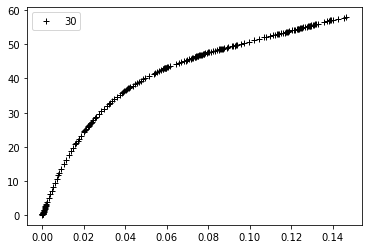

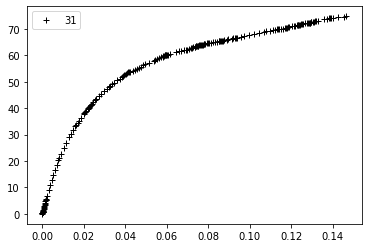

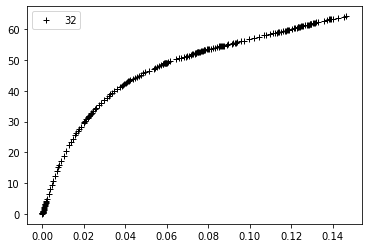

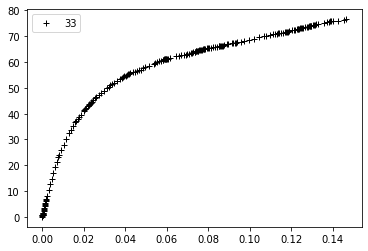

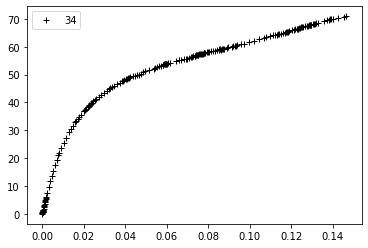

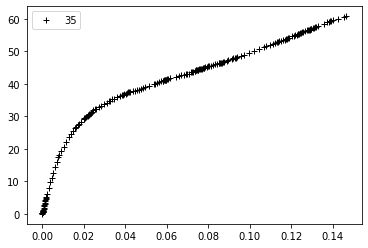

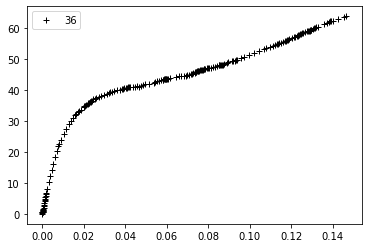

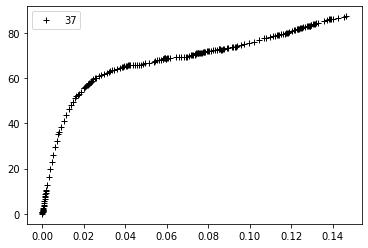

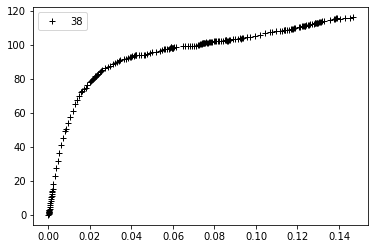

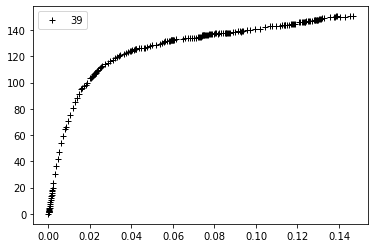

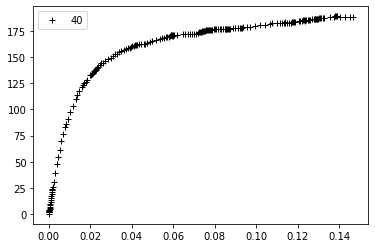

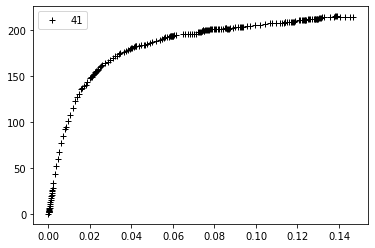

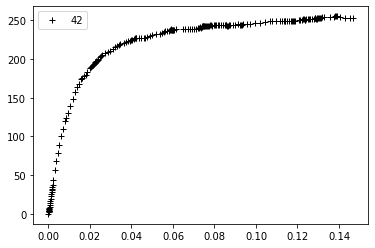

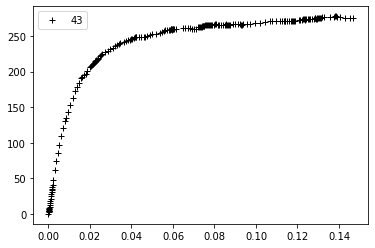

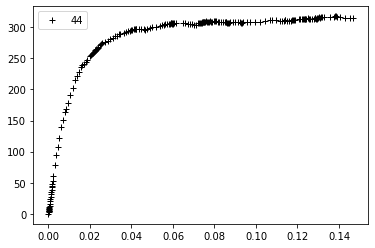

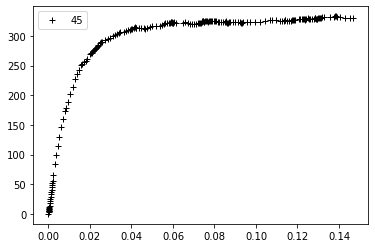

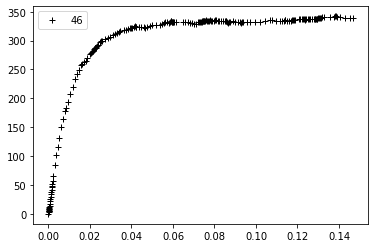

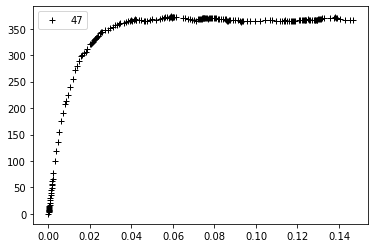

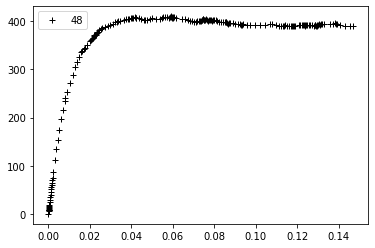

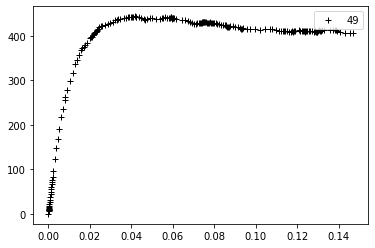

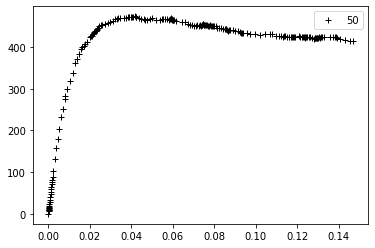

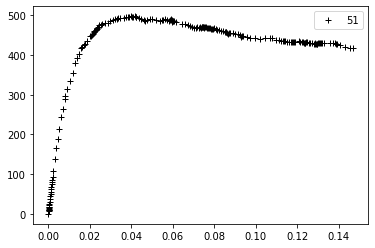

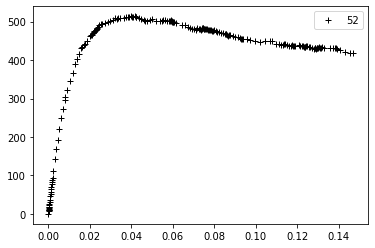

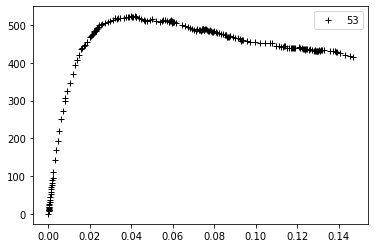

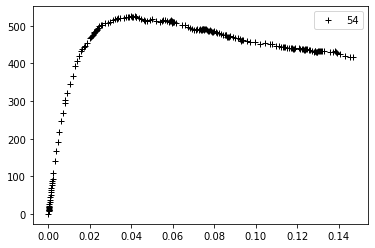

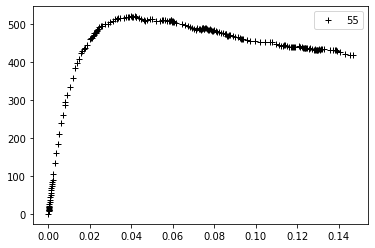

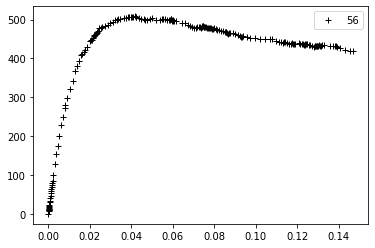

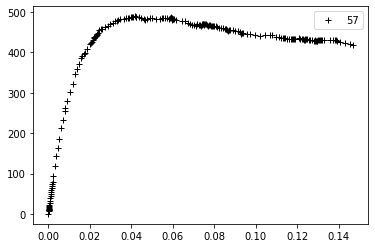

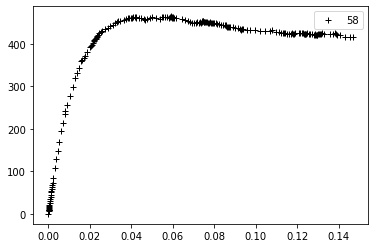

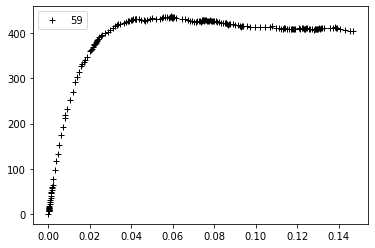

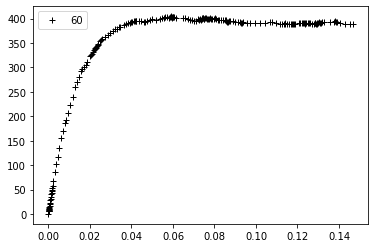

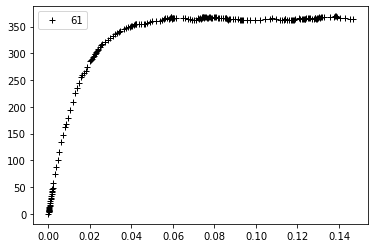

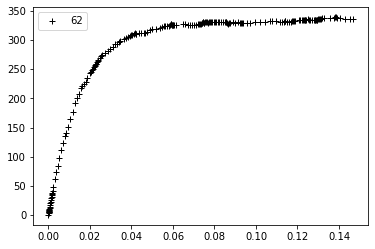

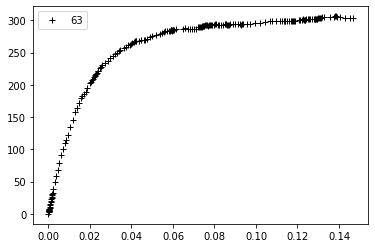

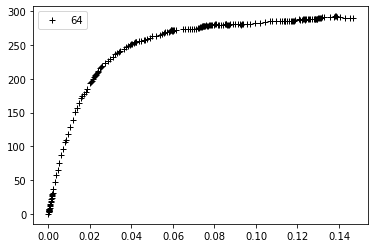

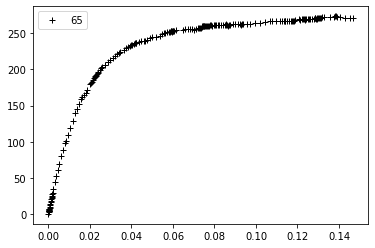

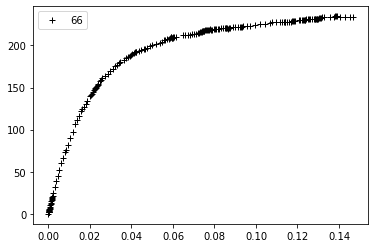

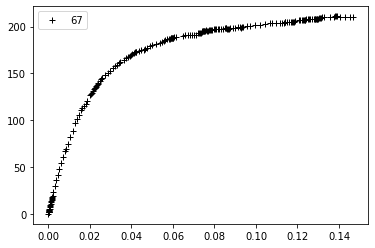

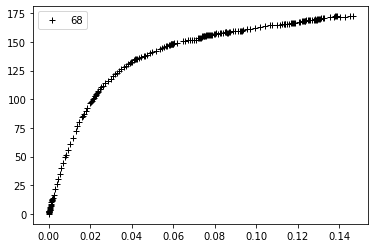

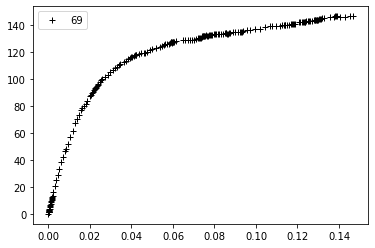

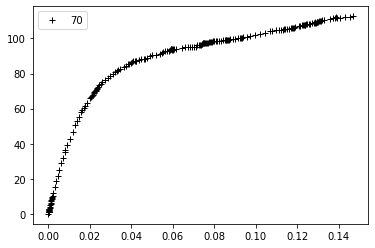

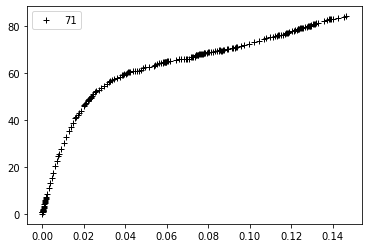

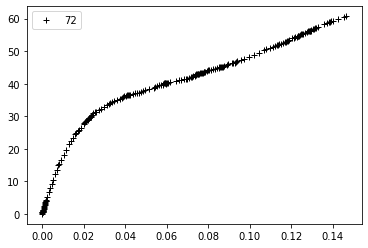

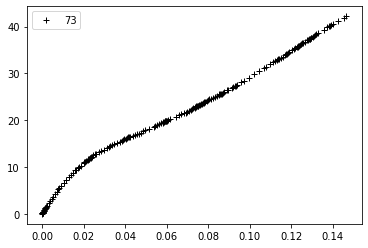

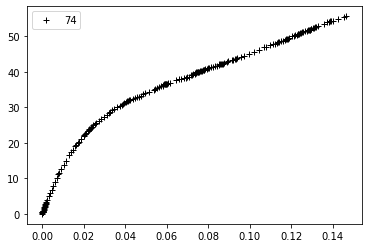

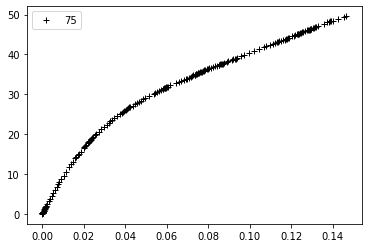

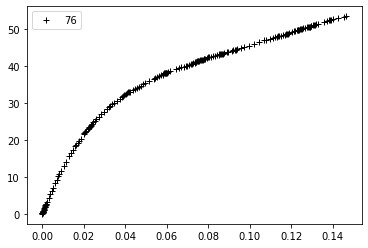

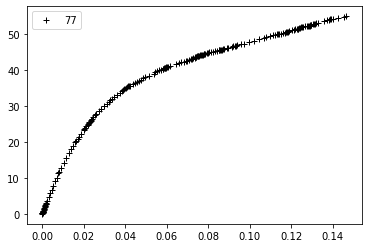

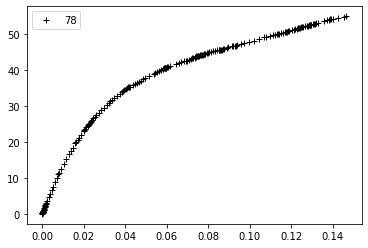

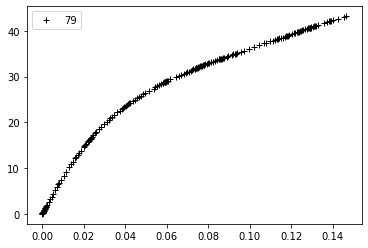

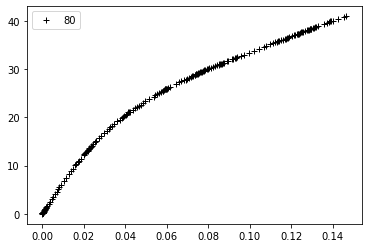

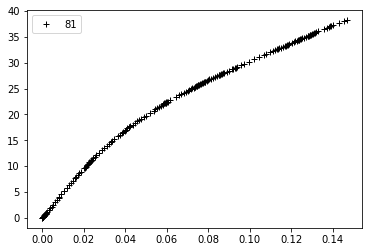

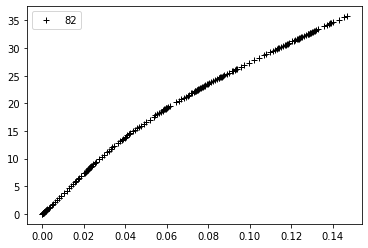

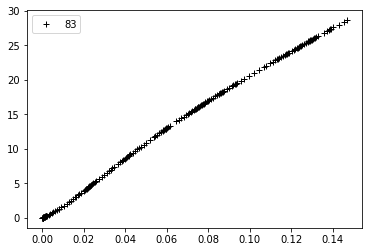

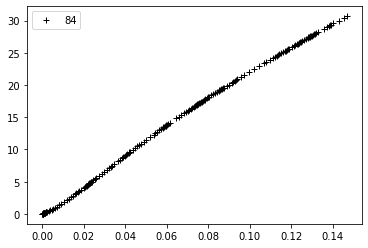

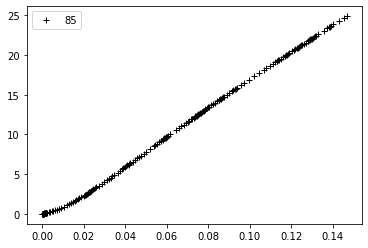

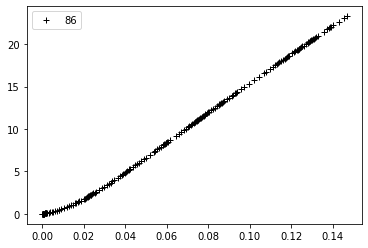

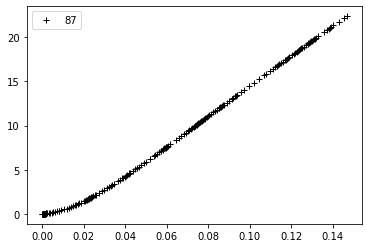

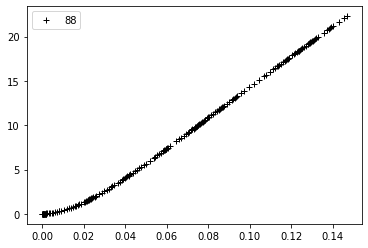

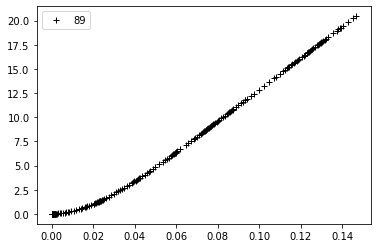

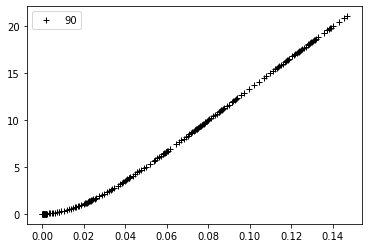

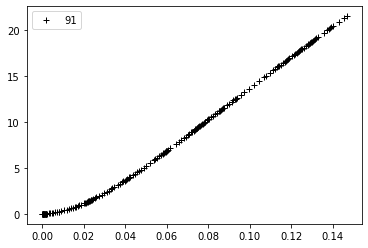

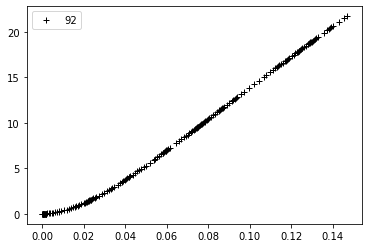

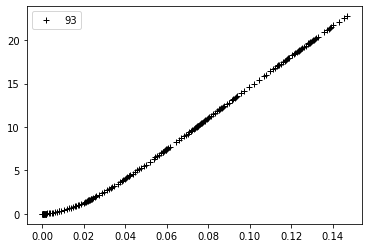

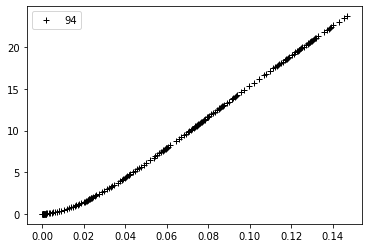

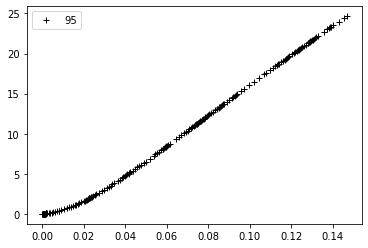

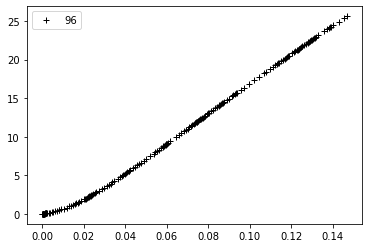

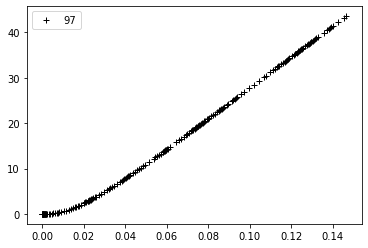

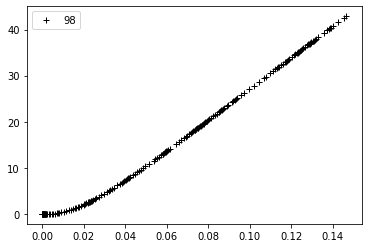

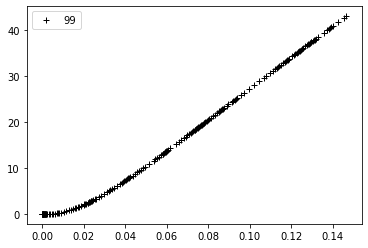

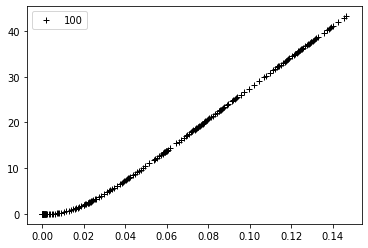

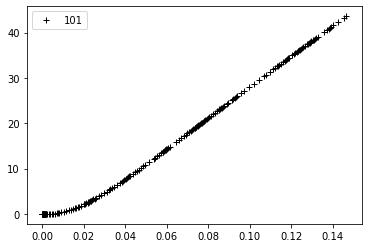

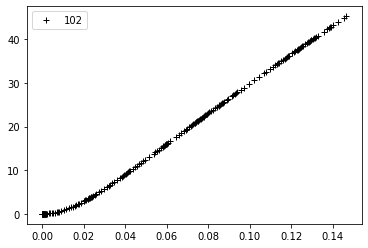

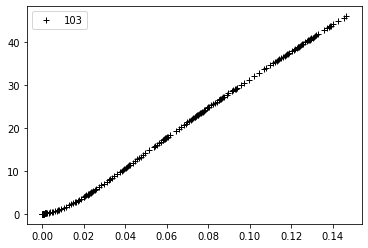

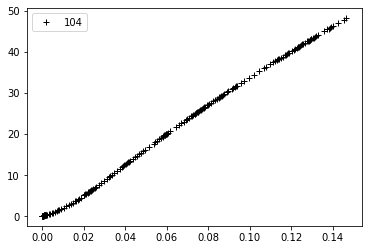

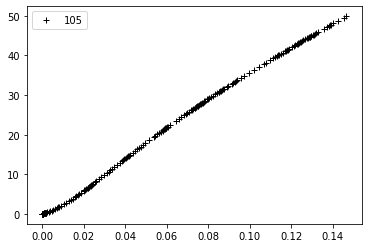

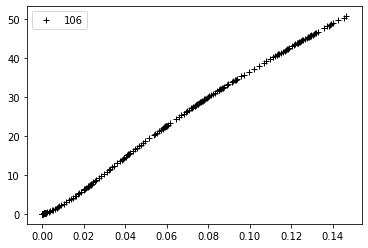

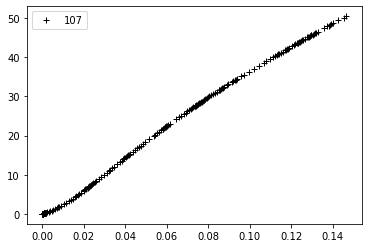

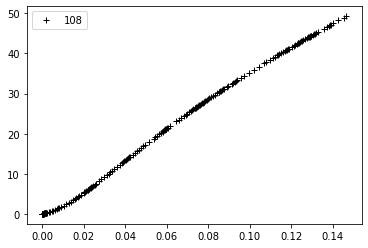

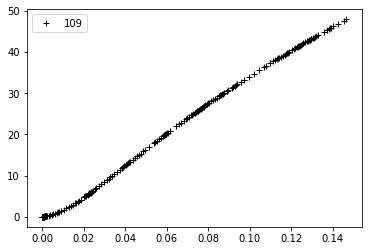

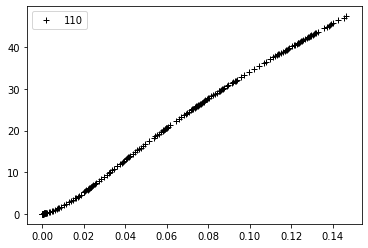

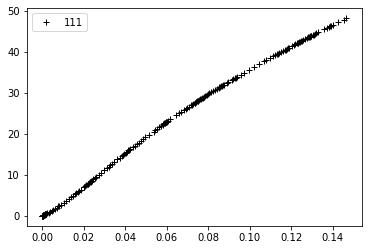

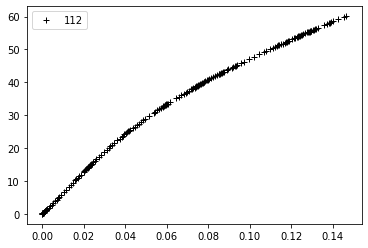

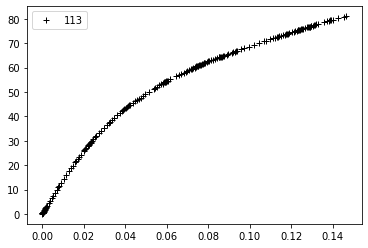

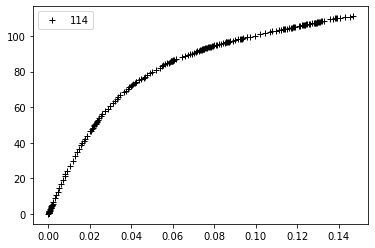

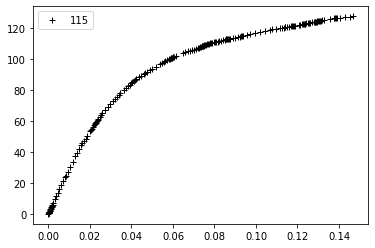

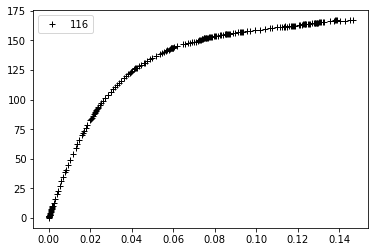

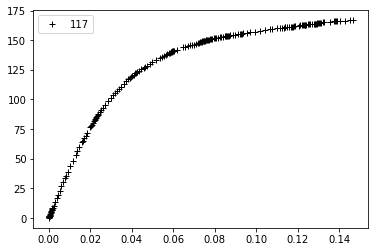

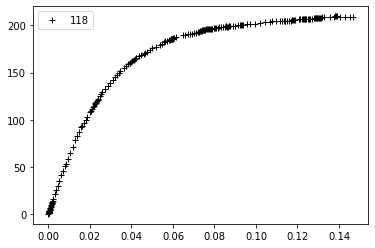

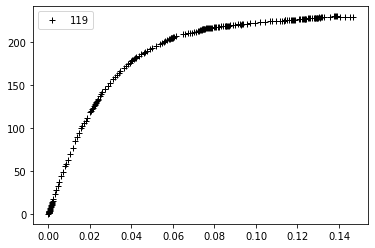

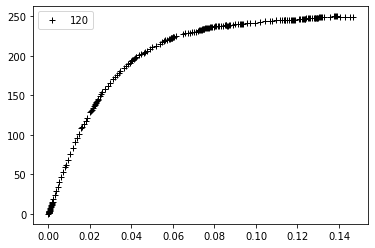

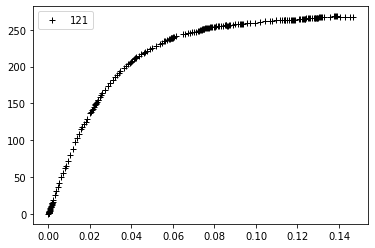

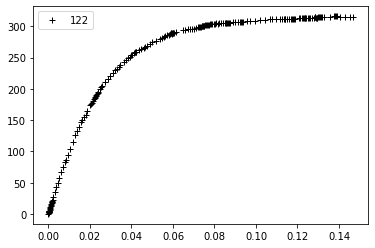

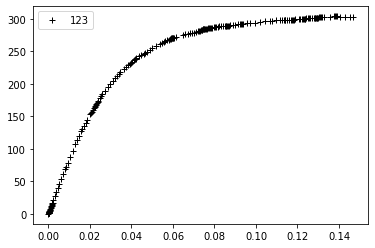

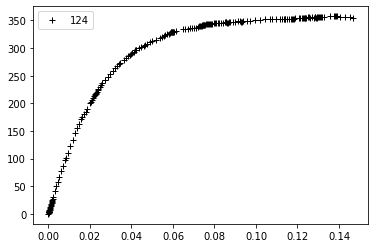

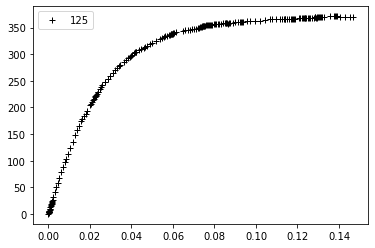

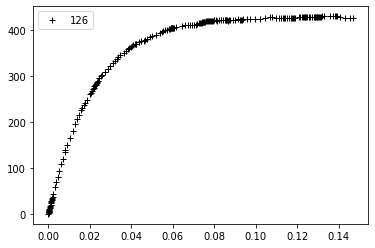

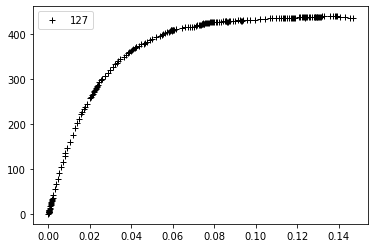

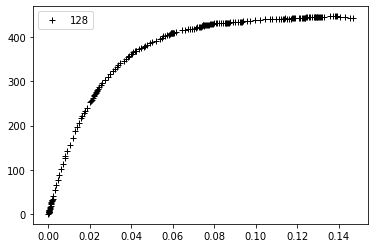

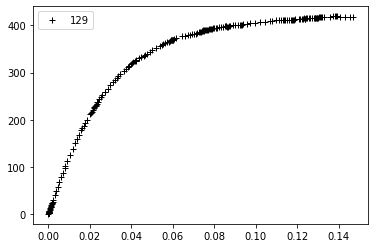

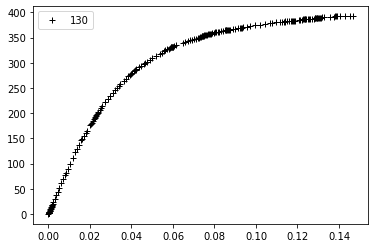

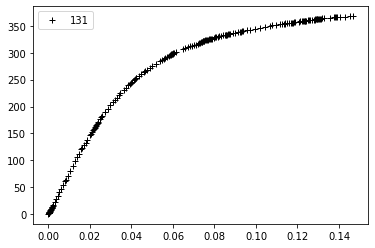

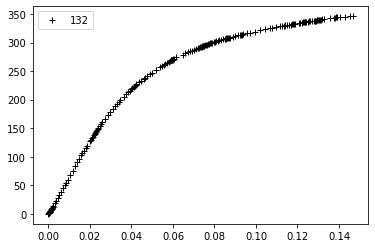

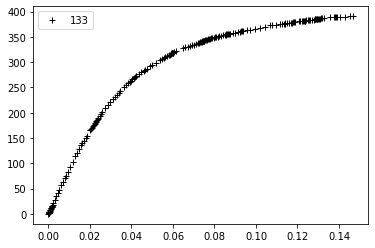

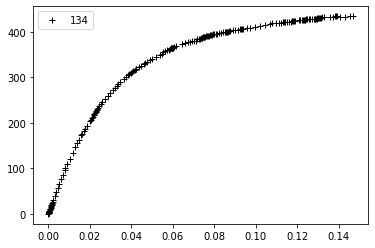

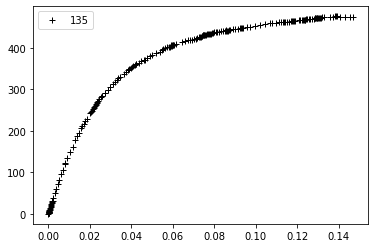

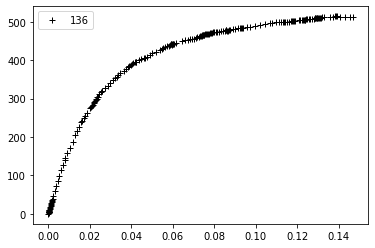

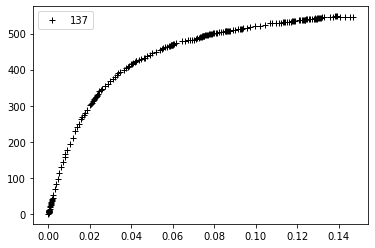

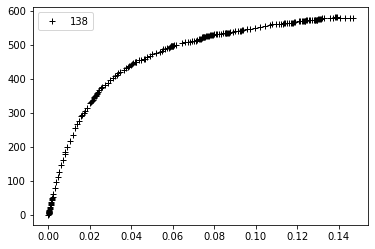

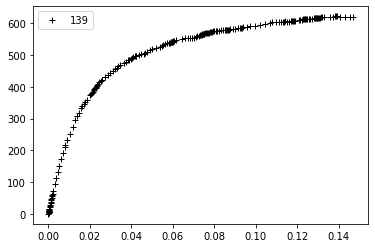

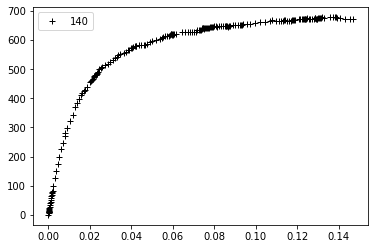

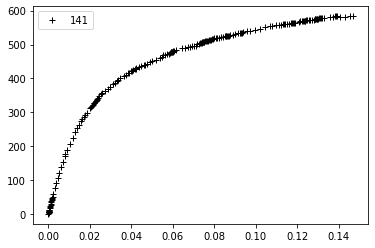

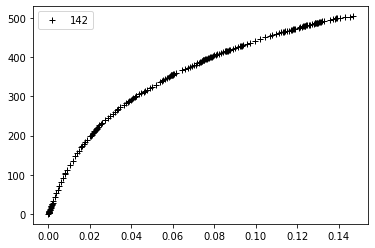

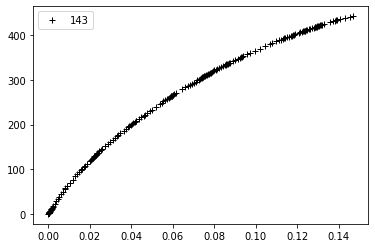

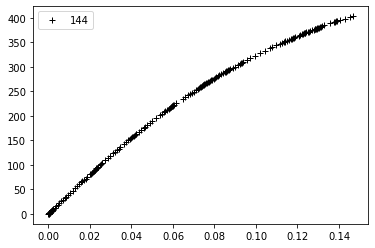

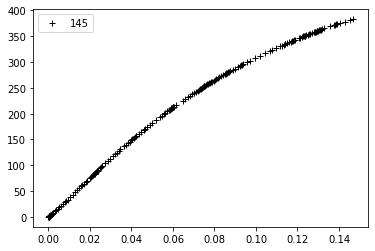

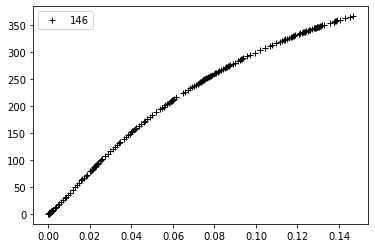

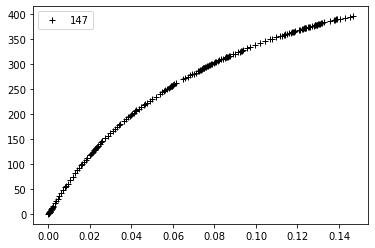

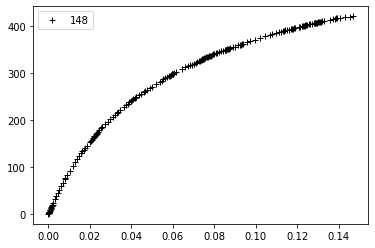

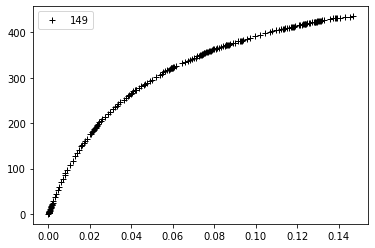

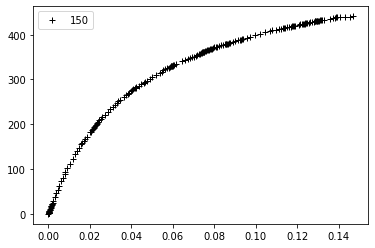

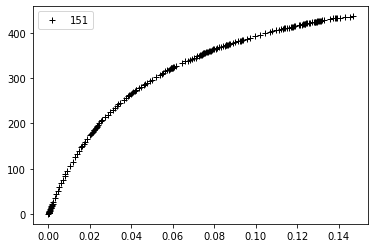

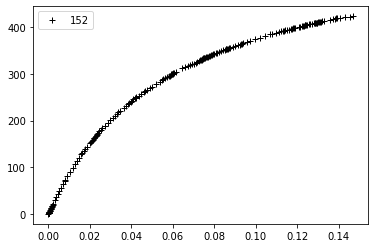

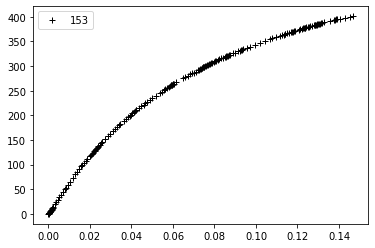

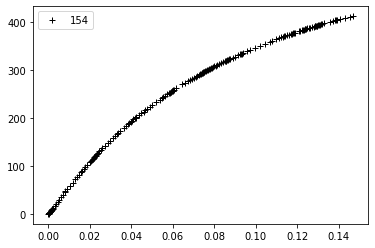

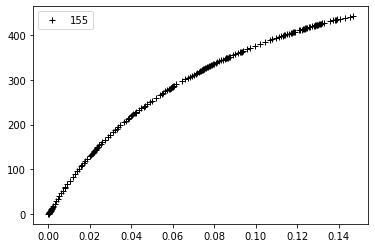

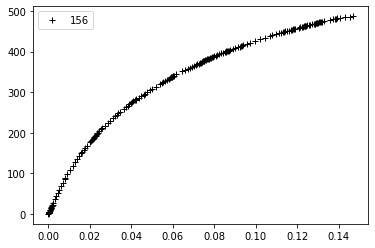

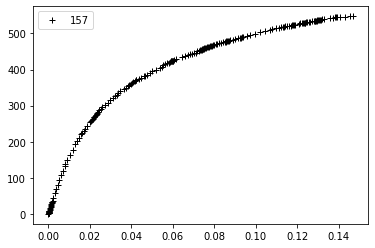

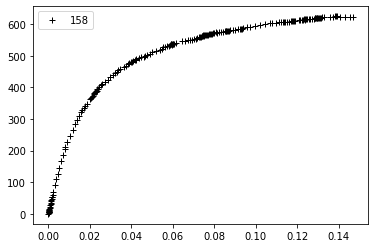

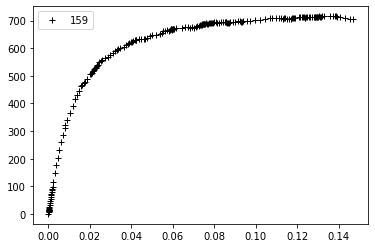

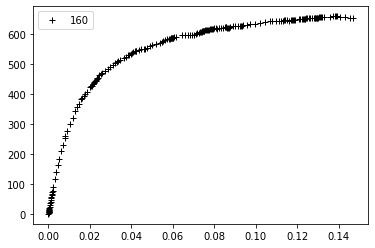

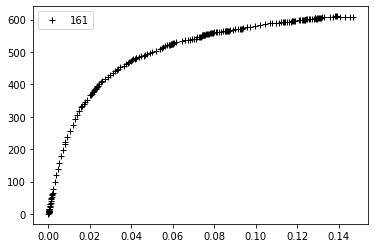

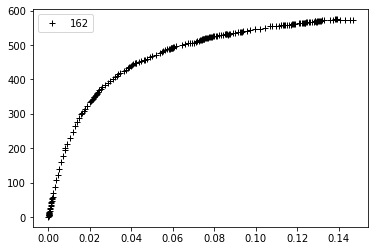

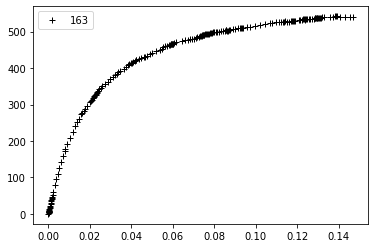

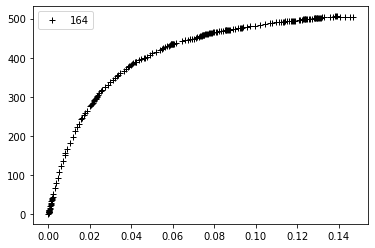

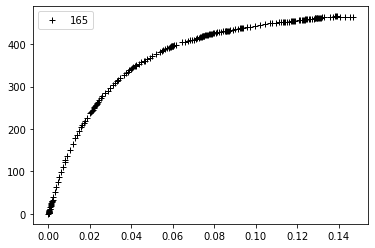

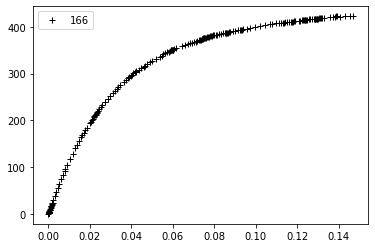

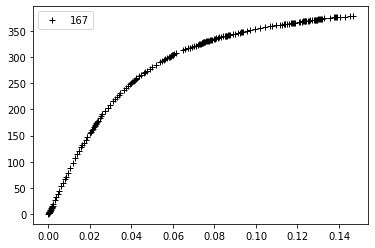

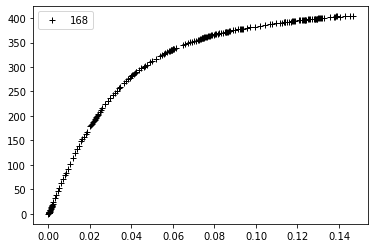

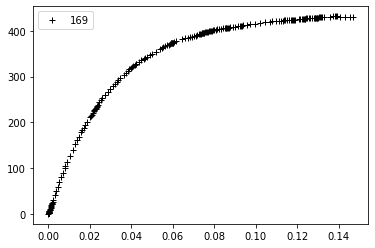

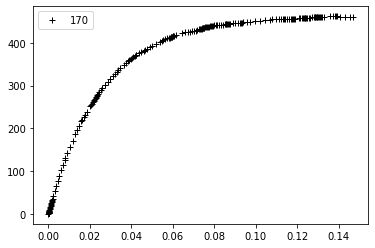

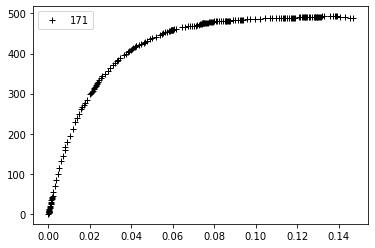

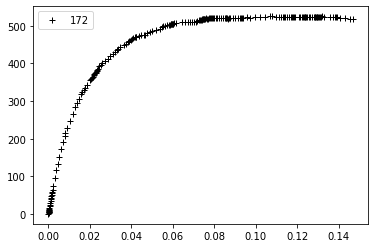

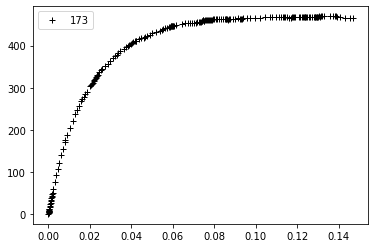

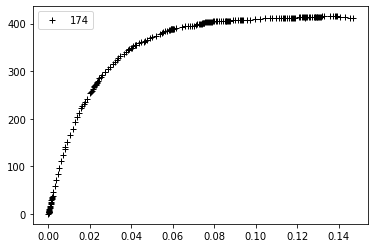

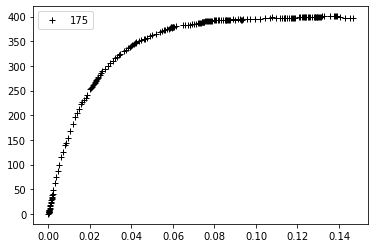

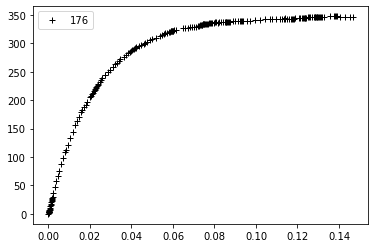

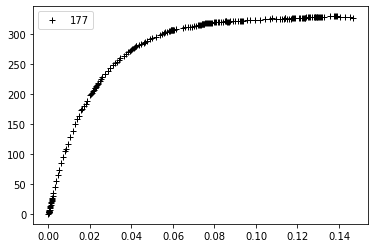

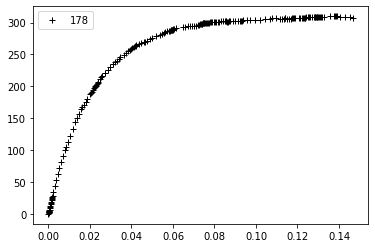

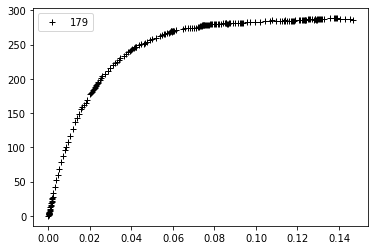

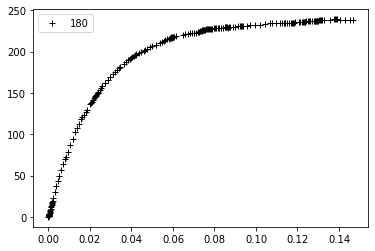

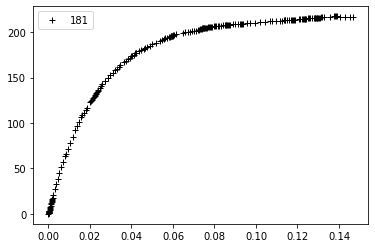

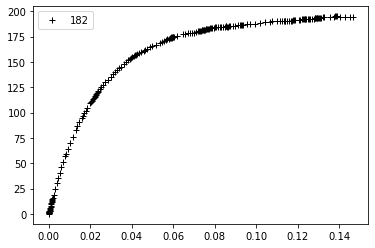

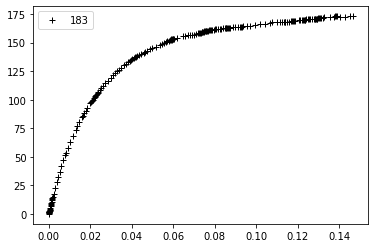

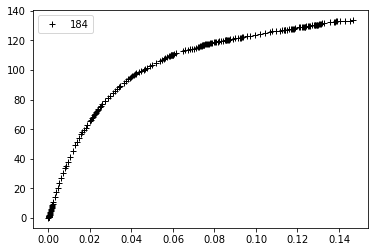

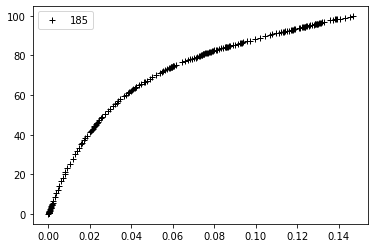

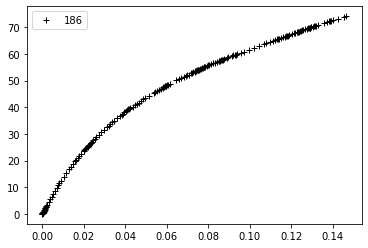

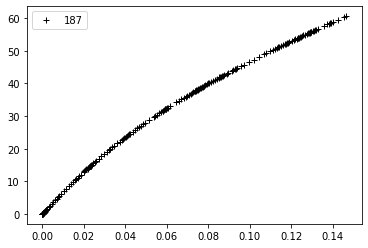

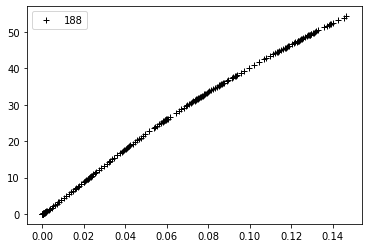

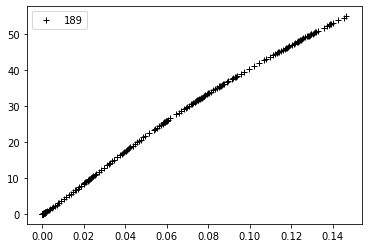

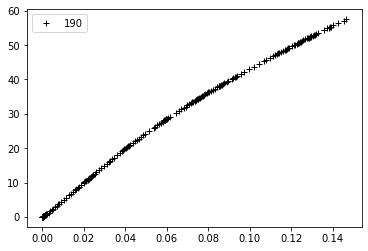

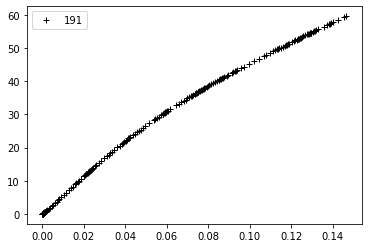

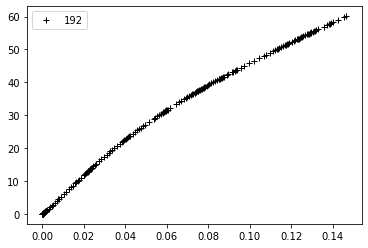

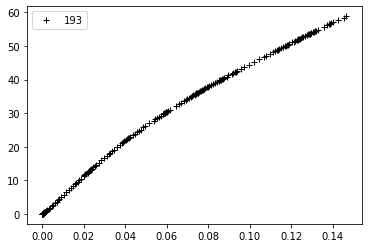

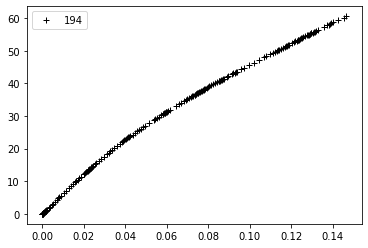

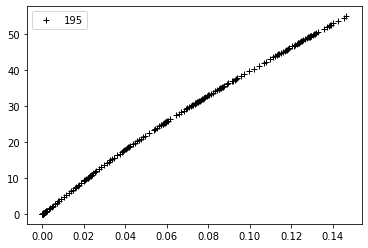

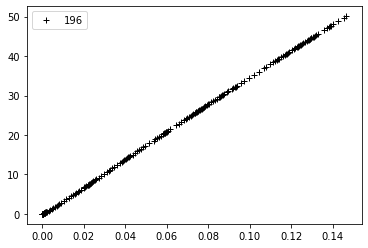

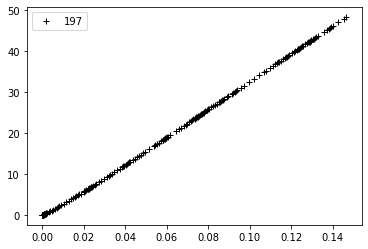

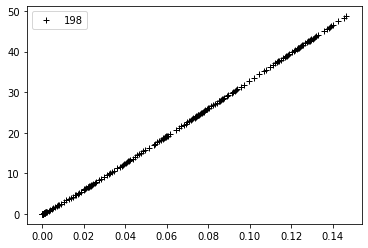

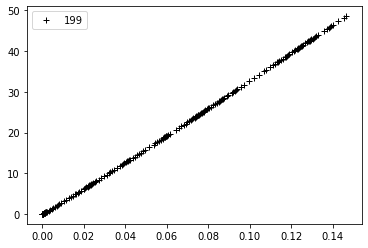

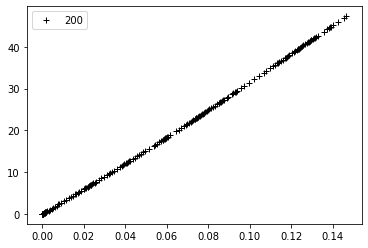

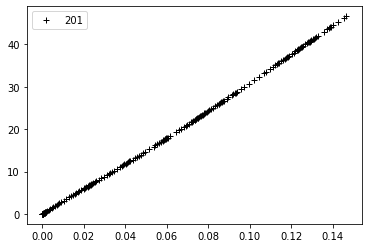

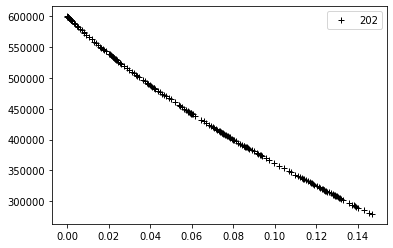

In [107]:
for i in range(len(stepping.currents_vec)):
    plt.figure()
    plt.plot(history_times, history_currents[:,i],'k+', label=str(i))
    plt.legend()

In [ ]:
for i in range(len(stepping.currents_vec)):
    plt.figure()
    plt.plot(history_times1, history_currents1[:,i],'k+', label=str(i))
    plt.plot(history_times2, history_currents2[:,i],'r+', label=str(i))
    # plt.plot(history_times, history_currents[:,i],'g+', label=str(i))


    plt.legend()

In [ ]:
plt.plot(stepping.arnoldi_trials[-1,:-3])

In [ ]:
stepping.arnoldi_trials[:,-3:]

In [ ]:
1e-5*stepping.results1['plasma_ind_on_coils']/stepping.dt_step

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(history_times, history_currents[:,32], 'k+')

In [ ]:
plt.plot(history_times)

In [ ]:
eq.tokamak.getCurrents()

In [ ]:
plt.imshow(eq.psi())
plt.colorbar()

In [ ]:
psifull = eq.tokamak.calcPsiFromGreens(pgreen=eq._pgreen)

In [ ]:
plt.imshow((psifull-eq.tokamak.calcPsiFromGreens(pgreen=eq._pgreen)))
plt.colorbar()

In [ ]:
for i,labeli in enumerate(MASTU_coils.coils_dict.keys()):
    if labeli[:2] == 'pa':
        eq.tokamak[labeli].current = 0

In [ ]:
np.max(psifull-eq.tokamak.calcPsiFromGreens(pgreen=eq._pgreen))-np.min(psifull-eq.tokamak.calcPsiFromGreens(pgreen=eq._pgreen))

In [ ]:
0.0062980520925785145/(np.max(psifull)-np.min(psifull))

In [ ]:
stepping.NK.solve(eq, profiles, rel_convergence=1e-9, verbose=True, grad_eps=0.001, conv_crit=.3)

In [ ]:
profiles = freegs.jtor.ConstrainPaxisIp(2e3, # Plasma pressure on axis [Pascals]
                                        8e5, # Plasma current [Amps]
                                        0.5, # vacuum f = R*Bt
                                        alpha_m = 1.0,
                                        alpha_n = 2.0)

In [ ]:
np.linalg.norm(stepping.NK._F(eq.plasma_psi))

In [ ]:
stepping.evol_currents.determine_stepsize(tot_dt=.00000001)

In [ ]:
stepping.evol_currents.stepper_adapt(stepping.currents_vec, U_active, dR=0)-stepping.currents_vec

In [ ]:
plt.plot(stepping.G[:,1])

In [ ]:
stepping.currents_vec

In [ ]:
v, w = np.linalg.eig(MASTU_coils.coil_self_ind)

In [ ]:
invm = np.linalg.inv(stepping.evol_currents.R_matrix[:-1,:-1]+MASTU_coils.coil_self_ind/.005)

In [ ]:
v, w = np.linalg.eig(np.matmul(invm, MASTU_coils.coil_self_ind/.005))

In [ ]:
invm = np.linalg.inv(stepping.evol_currents.R_matrix[:-1,:-1]+MASTU_coils.coil_self_ind/.0005)
v, w = np.linalg.eig(np.matmul(invm, MASTU_coils.coil_self_ind/.0005))
w = w[np.argsort(-v)]

In [ ]:
plt.plot(v)

In [ ]:
plt.plot(stepping.w[:,3])

In [ ]:
stepping.w[:,0][-1]

In [ ]:
MASTU_coils.coil_self_ind